# CNN 2D para Detección de Parkinson (Baseline con Augmentation + Optuna)
## Baseline Model - Train/Val/Test Split + Hyperparameter Optimization

Este notebook entrena un modelo **CNN2D simple** (sin Domain Adaptation) para clasificación binaria Parkinson vs Healthy **usando data augmentation** y **optimización automática de hiperparámetros con Optuna**.

### Pipeline:
1. **Setup**: Configuración del entorno
2. **Data Loading**: Carga de datos CON augmentation
3. **Split**: Train/Val/Test estratificado (70/15/15)
4. **Optuna Optimization**: Optimización automática de hiperparámetros (20 configuraciones)
5. **Final Training**: Re-entrenamiento con mejores hiperparámetros + early stopping
6. **Evaluation**: Métricas completas en test set
7. **Visualization**: Gráficas de progreso y resultados

### Arquitectura:
Este modelo usa el **mismo Feature Extractor** que CNN2D_DA (arquitectura Ibarra 2023) pero **sin Domain Adaptation**:
- 2 bloques Conv2D → BN → ReLU → MaxPool(3×3) → Dropout
- Solo cabeza de clasificación PD (sin GRL ni cabeza de dominio)

### Data Augmentation:
- Pitch shifting
- Time stretching
- Noise injection
- SpecAugment (máscaras de frecuencia/tiempo)
- Factor: ~5x más datos

### Comparación:
- **Este notebook**: Modelo CNN2D con augmentation (mejora generalización)
- **cnn_da_training.ipynb**: Modelo CNN2D_DA sin augmentation (paper exacto)
- El augmentation permite entrenar con más datos y mejorar robustez


In [35]:
# ============================================================
# CONFIGURACIÓN PARA GOOGLE COLAB
# ============================================================
# DESCOMENTA TODO EL BLOQUE SI EJECUTAS EN COLAB

from google.colab import drive
drive.mount("/content/drive")

import os, sys, subprocess

# Configuración - AJUSTA ESTOS VALORES SI ES NECESARIO
COMPUTER_NAME = "ZenBook"
PROJECT_DIR = "parkinson-voice-uncertainty"
BRANCH = "feature/feature/firstTraining"

BASE = "/content/drive/Othercomputers"
PROJ = os.path.join(BASE, COMPUTER_NAME, PROJECT_DIR)

# Función auxiliar
def sh(*args, check=False):
    print("$", " ".join(args))
    res = subprocess.run(args, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    print(res.stdout)
    if check and res.returncode != 0:
        raise RuntimeError("Command failed")
    return res.returncode

# Verificaciones
assert os.path.isdir(os.path.join(BASE, COMPUTER_NAME)), f"No encuentro {COMPUTER_NAME} en {BASE}"
assert os.path.isdir(PROJ), f"No encuentro el repo en: {PROJ}"

# Agregar al path
if PROJ not in sys.path:
    sys.path.insert(0, PROJ)

# Configurar Git
sh("git", "config", "--global", "--add", "safe.directory", PROJ)
sh("git", "-C", PROJ, "fetch", "--all", "--prune")
sh("git", "-C", PROJ, "branch", "--show-current")

# Cambiar a rama
rc = sh("git", "-C", PROJ, "checkout", BRANCH)
if rc != 0:
    sh("git", "-C", PROJ, "checkout", "-b", BRANCH, f"origin/{BRANCH}")

# Actualizar
sh("git", "-C", PROJ, "pull", "origin", BRANCH)

# Instalar dependencias con manejo de errores mejorado
req = os.path.join(PROJ, "requirements.txt")
if os.path.exists(req):
    os.chdir("/content")
    print("Instalando dependencias...")
    # Instalar dependencias críticas primero
    sh("python", "-m", "pip", "install", "-q", "optuna>=3.0.0")
    sh("python", "-m", "pip", "install", "-q", "torch>=1.9.0")
    sh("python", "-m", "pip", "install", "-q", "torchvision>=0.10.0")
    sh("python", "-m", "pip", "install", "-q", "scikit-learn>=1.0.0")
    sh("python", "-m", "pip", "install", "-q", "librosa>=0.8.1")
    sh("python", "-m", "pip", "install", "-q", "soundfile>=0.10.3")
    # Instalar el resto
    sh("python", "-m", "pip", "install", "-q", "-r", req)
    print("Dependencias instaladas correctamente")
else:
    print("⚠️  No se encontró requirements.txt, instalando dependencias básicas...")
    sh("python", "-m", "pip", "install", "-q", "optuna>=3.0.0", "torch>=1.9.0", "scikit-learn>=1.0.0")

os.chdir(PROJ)

# Verificar que optuna esté disponible
try:
    import optuna
    print(f"✅ Optuna {optuna.__version__} disponible")
except ImportError as e:
    print(f"❌ Error importando optuna: {e}")
    print("Reinstalando optuna...")
    sh("python", "-m", "pip", "install", "--force-reinstall", "optuna>=3.0.0")

# Autoreload
try:
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
    print("Autoreload activo")
except Exception as e:
    print(f"No se activó autoreload: {e}")

print(f"Repo listo en: {PROJ}")
sh("git", "-C", PROJ, "branch", "--show-current")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
$ git config --global --add safe.directory /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty

$ git -C /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty fetch --all --prune
Fetching origin

$ git -C /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty branch --show-current
feature/feature/firstTraining

$ git -C /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty checkout feature/feature/firstTraining
M	.gitignore
M	.ipynb_checkpoints/parkinson_voice_analysis-checkpoint.ipynb
M	README.md
M	bash.exe.stackdump
M	checkpoints/cnn2d_optuna_best_params.json
M	checkpoints/cnn2d_optuna_trials.csv
M	data/README.md
M	data/vowels_healthy/healthy_diverse_metadata.json
M	data_preparation/sample_healthy_data.py
M	data_preparation/verify_sampling.py
M	docs/CNN2D_TRAINING_SUMMARY.md
M	docs/CONFIGURACION_VALIDATION.md

0

In [36]:
# ============================================================
# CONFIGURAR ENTORNO Y DEPENDENCIAS
# ============================================================

import sys
from pathlib import Path

# Agregar el directorio raíz del proyecto al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importar el gestor de dependencias centralizado
from modules.core.dependency_manager import setup_notebook_environment

# Configurar el entorno automáticamente
# Esto verifica e instala todas las dependencias necesarias
success = setup_notebook_environment(auto_install=True, verbose=True)

if not success:
    print("Error configurando el entorno")
    print("Intenta instalar manualmente: pip install -r requirements.txt")
    import sys
    sys.exit(1)

print("="*70)


🚀 Configurando entorno para notebook...
🔍 Información del entorno:
   python_version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
   platform: linux
   is_colab: True
   is_jupyter: True
   working_directory: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty
   torch_version: 2.8.0+cu126
   cuda_available: True
🔍 Estado de dependencias:
   ✅ PyTorch
   ✅ TorchVision
   ✅ NumPy
   ✅ Pandas
   ✅ Scikit-learn
   ✅ Matplotlib
   ✅ Seaborn
   ✅ Librosa
   ✅ SoundFile
   ✅ Optuna
   ✅ Jupyter

✅ Entorno listo - todas las dependencias disponibles


In [37]:
# ============================================================
# CONFIGURACIÓN COMPLETA DEL EXPERIMENTO (PAPER IBARRA 2023)
# ============================================================

print("="*70)
print("CONFIGURACIÓN DEL EXPERIMENTO - PAPER IBARRA 2023")
print("="*70)

# ============================================================
# CONFIGURACIÓN DEL OPTIMIZADOR (SGD como en el paper)
# ============================================================
OPTIMIZER_CONFIG = {
    "type": "SGD",
    "learning_rate": 0.1,
    "momentum": 0.9,
    "weight_decay": 1e-4,  # Cambiado de 0.0 a 1e-4 para regularización
    "nesterov": True  # Agregado Nesterov momentum para mejor convergencia
}

# ============================================================
# CONFIGURACIÓN DEL SCHEDULER (StepLR como en el paper)
# ============================================================
SCHEDULER_CONFIG = {
    "type": "StepLR",
    "step_size": 10,
    "gamma": 0.1
}

# ============================================================
# CONFIGURACIÓN DEL K-FOLD CROSS-VALIDATION
# ============================================================
KFOLD_CONFIG = {
    "n_splits": 10,
    "shuffle": True,
    "random_state": 42,
    "stratify_by_speaker": True
}

# ============================================================
# CONFIGURACIÓN DE CLASS WEIGHTS (para balancear clases)
# ============================================================
CLASS_WEIGHTS_CONFIG = {
    "enabled": True,
    "method": "inverse_frequency"  # 1/frequency
}

# ============================================================
# CONFIGURACIÓN DE FILTRADO DE VOCAL /a/
# ============================================================
VOCAL_FILTER_CONFIG = {
    "enabled": True,
    "target_vocal": "a",  # Solo vocal /a/ como en el paper
    "filter_healthy": True,
    "filter_parkinson": True
}

# ============================================================
# CONFIGURACIÓN DE ENTRENAMIENTO
# ============================================================
TRAINING_CONFIG = {
    "n_epochs": 100,
    "early_stopping_patience": 10,  # Reducido de 15 a 10 para evitar overfitting
    "batch_size": 32,
    "num_workers": 0,
    "save_best_model": True
}

# ============================================================
# CONFIGURACIÓN DE OPTUNA (OPTIMIZACIÓN DE HIPERPARÁMETROS)
# ============================================================
# Optuna reemplaza a Optuna - más moderno, sin problemas de instalación
OPTUNA_CONFIG = {
    "enabled": True,
    "experiment_name": "cnn2d_optuna_optimization",
    "n_trials": 30,  # Número de configuraciones a probar
    "n_epochs_per_trial": 10,  # Épocas por configuración (reducido de 20 a 10)
    "metric": "f1",  # Métrica a optimizar
    "direction": "maximize",  # maximize o minimize
    "pruning_enabled": True,  # Habilitar pruning agresivo
    "pruning_patience": 3,  # Cortar trial si no mejora en 3 épocas
    "pruning_min_trials": 2  # Mínimo 2 épocas antes de aplicar pruning
}

# ============================================================
# CONFIGURACIÓN DE DATOS
# ============================================================
DATA_CONFIG = {
    "test_size": 0.15,
    "val_size": 0.15,
    "random_state": 42,
    "stratify": True
}

# ============================================================
# CONFIGURACIÓN DE WEIGHTS & BIASES
# ============================================================
WANDB_CONFIG = {
    "project_name": "parkinson-voice-uncertainty",
    "enabled": True,
    "api_key": "b452ba0c4bbe61d8c58e966aa86a9037ae19594e",
    "entity": None,  # Usar cuenta personal por defecto
    "tags": ["cnn2d", "parkinson", "voice", "uncertainty"],
    "notes": "CNN2D para detección de Parkinson con incertidumbre",
}

# Configuración de monitoreo de entrenamiento
TRAINING_MONITOR_CONFIG = {
    "use_wandb": True,
    "plot_every": 5,  # Cada 5 épocas
    "save_plots": True,
    "plot_metrics": ["loss", "f1", "accuracy", "precision", "recall"],
    "log_gradients": False,  # Deshabilitado para ahorrar espacio
    "log_parameters": True,
    "log_frequency": 1,  # Cada época
}


CONFIGURACIÓN DEL EXPERIMENTO - PAPER IBARRA 2023


In [38]:
# ============================================================
# DETECTAR ENTORNO Y CONFIGURAR RUTAS
# ============================================================

# Este import funciona desde cualquier subdirectorio del proyecto
import sys
from pathlib import Path

# Buscar y agregar la raíz del proyecto al path
current_dir = Path.cwd()
for _ in range(10):
    if (current_dir / "modules").exists():
        if str(current_dir) not in sys.path:
            sys.path.insert(0, str(current_dir))
        break
    current_dir = current_dir.parent

# Importar la función de configuración de notebooks
from modules.core.notebook_setup import setup_notebook

# Configurar automáticamente: path + entorno (Local/Colab) + rutas
ENV, PATHS = setup_notebook(verbose=True)


Raíz del proyecto agregada al path: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty
CONFIGURACIÓN DE ENTORNO
Entorno detectado: COLAB
Ruta base: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty
Cache original: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/cache/original
Cache augmented: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/cache/augmented

MODO COLAB: Usando rutas de Google Drive


## 1. Setup y Configuración


In [ ]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import json
import numpy as np
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Agregar módulos propios al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importar módulos propios
from modules.models.cnn2d.model import CNN2D
from modules.models.common.training_utils import print_model_summary
from modules.models.cnn2d.training import train_model, detailed_evaluation, print_evaluation_report
from modules.models.cnn2d.visualization import plot_training_history, analyze_spectrogram_stats
from modules.models.cnn2d.utils import plot_confusion_matrix
from modules.core.utils import create_10fold_splits_by_speaker
from modules.core.dataset import (
    load_spectrograms_cache,
    to_pytorch_tensors,
    DictDataset,
)


# Imports para Optuna (optimización de hiperparámetros - reemplaza Optuna)
from modules.core.cnn2d_optuna_wrapper import optimize_cnn2d, create_cnn2d_optimizer
from modules.core.optuna_optimization import OptunaOptimizer

# Imports para Weights & Biases (monitoreo en tiempo real)
from modules.core.training_monitor import create_training_monitor, test_wandb_connection

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Reporte de configuración
print("="*70)
print("CNN 2D TRAINING - BASELINE CON AUGMENTATION")
print("="*70)
print(f"Librerías cargadas correctamente")
print(f"Dispositivo: {device}")
print(f"PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Data augmentation: ACTIVADO (~5x datos)")
print("="*70)


CNN 2D TRAINING - BASELINE CON AUGMENTATION
Librerías cargadas correctamente
Dispositivo: cuda
PyTorch: 2.8.0+cu126
GPU: Tesla T4
Data augmentation: ACTIVADO (~5x datos)


## 2. Carga de Datos

Carga de datos preprocesados CON augmentation para mejorar generalización del modelo baseline.


In [ ]:
# ============================================================
# CARGAR DATOS HEALTHY DESDE CACHE ORIGINAL
# ============================================================

print("Cargando datos Healthy desde cache original...")
print("="*60)

from modules.core.dataset import load_spectrograms_cache

# Cargar datos healthy desde cache original usando rutas dinámicas
cache_healthy_path = PATHS['cache_original'] / "healthy_ibarra.pkl"
healthy_dataset = load_spectrograms_cache(str(cache_healthy_path))

if healthy_dataset is None:
    raise FileNotFoundError(f"No se encontró el cache de datos healthy en {cache_healthy_path}")

# Convertir a tensores PyTorch
X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(healthy_dataset)

print(f"Healthy cargado exitosamente:")
print(f"   - Espectrogramas: {X_healthy.shape[0]}")
print(f"   - Shape: {X_healthy.shape}")
print(f"   - Ruta: {cache_healthy_path}")


Cargando datos Healthy desde cache original...
Cache cargado: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/cache/original/healthy_ibarra.pkl
   Tamaño: 933.5 MB
   Muestras: 12029
PyTorch tensors listos:
  - X: (12029, 1, 65, 41)
  - y_task: (12029,)  (dist={0: 12029})
  - y_domain: (12029,)  (K dominios=4)
Healthy cargado exitosamente:
   - Espectrogramas: 12029
   - Shape: torch.Size([12029, 1, 65, 41])
   - Ruta: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/cache/original/healthy_ibarra.pkl


In [ ]:
# ============================================================
# CARGAR DATOS PARKINSON DESDE CACHE ORIGINAL
# ============================================================

print("Cargando datos Parkinson desde cache original...")
print("="*60)

# Cargar datos parkinson desde cache original usando rutas dinámicas
cache_parkinson_path = PATHS['cache_original'] / "parkinson_ibarra.pkl"
parkinson_dataset = load_spectrograms_cache(str(cache_parkinson_path))

if parkinson_dataset is None:
    raise FileNotFoundError(f"No se encontró el cache de datos parkinson en {cache_parkinson_path}")

# Convertir a tensores PyTorch
X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(parkinson_dataset)

print(f"Parkinson cargado exitosamente:")
print(f"   - Espectrogramas: {X_parkinson.shape[0]}")
print(f"   - Shape: {X_parkinson.shape}")
print(f"   - Ruta: {cache_parkinson_path}")


Cargando datos Parkinson desde cache original...
Cache cargado: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/cache/original/parkinson_ibarra.pkl
   Tamaño: 1792.3 MB
   Muestras: 23097
PyTorch tensors listos:
  - X: (23097, 1, 65, 41)
  - y_task: (23097,)  (dist={0: 23097})
  - y_domain: (23097,)  (K dominios=4)
Parkinson cargado exitosamente:
   - Espectrogramas: 23097
   - Shape: torch.Size([23097, 1, 65, 41])
   - Ruta: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/cache/original/parkinson_ibarra.pkl


In [ ]:
# ============================================================
# INFORMACIÓN DE DATOS CARGADOS
# ============================================================

print("="*70)
print("INFORMACIÓN DE DATOS CARGADOS")
print("="*70)

print(f"Datos Healthy (desde cache original):")
print(f"   - Muestras: {len(healthy_dataset)}")
print(f"   - Shape de espectrogramas: {X_healthy.shape}")

print("="*70)


INFORMACIÓN DE DATOS CARGADOS
Datos Healthy (desde cache original):
   - Muestras: 12029
   - Shape de espectrogramas: torch.Size([12029, 1, 65, 41])


In [ ]:
# ============================================================
# CHECKPOINT INICIAL YA CREADO
# ============================================================

print("="*70)
print("CHECKPOINT INICIAL YA CREADO")
print("="*70)

print("✅ El checkpoint inicial ya fue creado ejecutando:")
print("   python research/create_initial_checkpoint.py")
print("\n📊 Resumen del checkpoint:")
print("   - Trials guardados: 24")
print("   - Trials completados: 13")
print("   - Mejor F1: 0.7313")
print("   - Mejor trial: 15")
print("   - Directorio: checkpoints/")

print("\n🚀 Ahora puedes continuar con la optimización de Optuna")
print("="*70)


CHECKPOINT INICIAL YA CREADO
✅ El checkpoint inicial ya fue creado ejecutando:
   python research/create_initial_checkpoint.py

📊 Resumen del checkpoint:
   - Trials guardados: 24
   - Trials completados: 13
   - Mejor F1: 0.7313
   - Mejor trial: 15
   - Directorio: checkpoints/

🚀 Ahora puedes continuar con la optimización de Optuna


In [ ]:
# ============================================================
# ANÁLISIS ESTADÍSTICO BÁSICO
# ============================================================

print("="*70)
print("ANÁLISIS ESTADÍSTICO BÁSICO")
print("="*70)

# Análisis estadístico básico
healthy_stats = analyze_spectrogram_stats(healthy_dataset, "HEALTHY")
parkinson_stats = analyze_spectrogram_stats(parkinson_dataset, "PARKINSON")

# Comparar diferencias
print(f"\nDIFERENCIAS ENTRE CLASES:")
print(f"   - Diferencia en media: {abs(healthy_stats['mean'] - parkinson_stats['mean']):.3f}")
print(f"   - Diferencia en std: {abs(healthy_stats['std'] - parkinson_stats['std']):.3f}")

print("\nConfiguración del experimento:")
print("   - Healthy: datos originales (baseline)")
print("   - Parkinson: datos con augmentation (mejor generalización)")
print("="*70)


ANÁLISIS ESTADÍSTICO BÁSICO

HEALTHY:
   • Número de espectrogramas: 12029
   • Shape típico: (65, 41)
   • Media: 0.000
   • Desviación estándar: 1.000
   • Min: -2.465
   • Max: 6.155

PARKINSON:
   • Número de espectrogramas: 23097
   • Shape típico: (65, 41)
   • Media: 0.000
   • Desviación estándar: 1.000
   • Min: -3.360
   • Max: 3.726

DIFERENCIAS ENTRE CLASES:
   - Diferencia en media: 0.000
   - Diferencia en std: 0.000

Configuración del experimento:
   - Healthy: datos originales (baseline)
   - Parkinson: datos con augmentation (mejor generalización)


In [ ]:
# ============================================================
# COMBINAR DATASETS
# ============================================================

print("="*70)
print("COMBINANDO DATASETS")
print("="*70)

# Combinar espectrogramas
X_combined = torch.cat([X_healthy, X_parkinson], dim=0)

# Crear labels: 0=Healthy, 1=Parkinson
y_combined = torch.cat([
    torch.zeros(len(X_healthy), dtype=torch.long),  # Healthy = 0
    torch.ones(len(X_parkinson), dtype=torch.long)  # Parkinson = 1
], dim=0)

print(f"\nDATASET COMBINADO:")
print(f"   - Total muestras: {len(X_combined)}")
print(f"   - Shape: {X_combined.shape}")
print(f"   - Healthy (0): {(y_combined == 0).sum().item()} ({(y_combined == 0).sum()/len(y_combined)*100:.1f}%)")
print(f"   - Parkinson (1): {(y_combined == 1).sum().item()} ({(y_combined == 1).sum()/len(y_combined)*100:.1f}%)")

balance_pct = (y_combined == 1).sum() / len(y_combined) * 100
if abs(balance_pct - 50) < 10:
    print(f"   ✓ Dataset razonablemente balanceado")
else:
    print(f"   ⚠ Dataset desbalanceado - class weights habilitados en config")

print("="*70)


COMBINANDO DATASETS

DATASET COMBINADO:
   - Total muestras: 35126
   - Shape: torch.Size([35126, 1, 65, 41])
   - Healthy (0): 12029 (34.2%)
   - Parkinson (1): 23097 (65.8%)
   ⚠ Dataset desbalanceado - class weights habilitados en config


In [ ]:
# ============================================================
# INSPECCIONAR METADATOS PARA SPEAKER IDS
# ============================================================

print("="*70)
print("VERIFICANDO METADATOS")
print("="*70)

# Verificar estructura de metadatos
if meta_healthy and len(meta_healthy) > 0:
    print(f"\n✓ meta_healthy disponible: {len(meta_healthy)} muestras")
    print(f"  Ejemplo de metadata[0]:")
    sample_meta = meta_healthy[0]
    if isinstance(sample_meta, dict):
        for key, value in list(sample_meta.items())[:5]:
            print(f"    - {key}: {value}")
    else:
        print(f"    Tipo: {type(sample_meta)}")
        print(f"    Valor: {sample_meta}")
else:
    print("  ✗ meta_healthy no disponible o vacío")

if meta_parkinson and len(meta_parkinson) > 0:
    print(f"\n✓ meta_parkinson disponible: {len(meta_parkinson)} muestras")
    print(f"  Ejemplo de metadata[0]:")
    sample_meta = meta_parkinson[0]
    if isinstance(sample_meta, dict):
        for key, value in list(sample_meta.items())[:5]:
            print(f"    - {key}: {value}")
    else:
        print(f"    Tipo: {type(sample_meta)}")
        print(f"    Valor: {sample_meta}")
else:
    print("  ✗ meta_parkinson no disponible o vacío")

print("="*70)


VERIFICANDO METADATOS

✓ meta_healthy disponible: 12029 muestras
  Ejemplo de metadata[0]:
    Tipo: <class 'modules.core.dataset.SampleMeta'>
    Valor: SampleMeta(subject_id='10', vowel_type='a_n', condition='unknown', filename='10-a_n.wav', segment_id=0, sr=44100)

✓ meta_parkinson disponible: 23097 muestras
  Ejemplo de metadata[0]:
    Tipo: <class 'modules.core.dataset.SampleMeta'>
    Valor: SampleMeta(subject_id='1037', vowel_type='a_h', condition='unknown', filename='1037-a_h.wav', segment_id=0, sr=44100)


## 3. Split Train/Val/Test

Split estratificado 70/15/15 para mantener proporciones de clases.


In [ ]:
# ============================================================
# 10-FOLD CROSS-VALIDATION ESTRATIFICADO POR HABLANTE
# ============================================================

print("="*70)
print("10-FOLD CROSS-VALIDATION (PAPER IBARRA 2023)")
print("="*70)

# Preparar metadata combinada para create_10fold_splits_by_speaker
# La metadata ya fue cargada antes con meta_healthy y meta_parkinson

# Crear lista de metadata combinada con labels
metadata_combined = []

# Agregar metadata de healthy (label=0)
for meta in meta_healthy:
    metadata_combined.append({
        "subject_id": meta.subject_id,
        "label": 0,  # Healthy
        "filename": meta.filename
    })

# Agregar metadata de parkinson (label=1)
for meta in meta_parkinson:
    metadata_combined.append({
        "subject_id": meta.subject_id,
        "label": 1,  # Parkinson
        "filename": meta.filename
    })

print(f"\n📊 Dataset info:")
print(f"   • Total samples: {len(X_combined)}")
print(f"   • Metadata entries: {len(metadata_combined)}")

# Crear 10-fold splits usando la función centralizada
# Esta función asegura que todos los samples de un speaker están en el mismo fold
fold_splits = create_10fold_splits_by_speaker(
    metadata_list=metadata_combined,
    n_folds=KFOLD_CONFIG["n_splits"],
    seed=KFOLD_CONFIG["random_state"]
)

# Para este notebook, usaremos el primer fold como ejemplo
# En el paper real se promedian los resultados de los 10 folds
train_indices = fold_splits[0]["train"]
val_indices = fold_splits[0]["val"]

# Crear splits de train/val usando los índices
X_train = X_combined[train_indices]
y_train = y_combined[train_indices]
X_val = X_combined[val_indices]
y_val = y_combined[val_indices]

# Para test, usamos un split separado del 15%
# TODO: Esto debería también usar split por speaker para evitar leakage
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined, y_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_combined
)

print(f"\nTAMAÑOS DE SPLITS:")
print(f"   - Train: {len(X_train)} ({len(X_train)/len(X_combined)*100:.1f}%)")
print(f"   - Val:   {len(X_val)} ({len(X_val)/len(X_combined)*100:.1f}%)")
print(f"   - Test:  {len(X_test)} ({len(X_test)/len(X_combined)*100:.1f}%)")

print(f"\nDISTRIBUCIÓN POR SPLIT:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    n_healthy = (y_split == 0).sum().item()
    n_parkinson = (y_split == 1).sum().item()
    print(f"   {split_name:5s}: HC={n_healthy:4d} ({n_healthy/len(y_split)*100:.1f}%), PD={n_parkinson:4d} ({n_parkinson/len(y_split)*100:.1f}%)")

print("="*70)


10-FOLD CROSS-VALIDATION (PAPER IBARRA 2023)

📊 Dataset info:
   • Total samples: 35126
   • Metadata entries: 35126

📊 10-Fold CV speaker-independent creado:
   Total hablantes: 2042
   Total muestras: 35126
   Folds: 10

   Fold 1 (ejemplo):
      Train: 31789 muestras
      Val:   3337 muestras

TAMAÑOS DE SPLITS:
   - Train: 31789 (90.5%)
   - Val:   3337 (9.5%)
   - Test:  5269 (15.0%)

DISTRIBUCIÓN POR SPLIT:
   Train: HC=10916 (34.3%), PD=20873 (65.7%)
   Val  : HC=1113 (33.4%), PD=2224 (66.6%)
   Test : HC=1804 (34.2%), PD=3465 (65.8%)


In [ ]:
# Agregar módulos propios al path
# El notebook está en research/, pero modules/ está en el directorio raíz
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# ============================================================
# CREAR DATALOADERS
# ============================================================

print("\n📦 CREANDO DATALOADERS...")

BATCH_SIZE = 32

# Importar DictDataset desde el módulo core

# Crear datasets con formato de diccionario
train_dataset = DictDataset(X_train, y_train)
val_dataset = DictDataset(X_val, y_val)
test_dataset = DictDataset(X_test, y_test)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches:   {len(val_loader)}")
print(f"   • Test batches:  {len(test_loader)}")
print(f"   • Batch size:    {BATCH_SIZE}")



📦 CREANDO DATALOADERS...
✅ DataLoaders creados:
   • Train batches: 994
   • Val batches:   53
   • Test batches:  83
   • Batch size:    32


In [ ]:
# ============================================================
# ANÁLISIS DE RESULTADOS DE OPTUNA
# ============================================================

print("="*70)
print("ANÁLISIS DE RESULTADOS")
print("="*70)

# Verificar que optuna_results esté disponible
if 'optuna_results' not in globals():
    print("❌ Error: optuna_results no está disponible.")
    print("   Ejecuta primero el bloque de optimización de Optuna.")
    print("="*70)
else:
    # Extraer resultados
    results_df = optuna_results["results_df"]
    best_params = optuna_results["best_params"]
    # analysis no está disponible en optuna_results, se omite

    print(f"📊 Resumen de la optimización:")
    print(f"   - Total configuraciones evaluadas: {len(results_df)}")
    print(f"   - Mejor F1-score encontrado: {results_df['f1'].max():.4f}")
    print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

    print(f"\n🏆 Mejores hiperparámetros encontrados:")
    for param, value in best_params.items():
        if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
            print(f"   - {param}: {value}")

    # Mostrar top 10 configuraciones
    print(f"\n📈 Top 10 configuraciones:")
    print("-" * 80)
    top_10 = results_df.nlargest(10, 'f1')
    for i, (idx, row) in enumerate(top_10.iterrows(), 1):
        print(f"{i:2d}. F1: {row['f1']:.4f} | "
              f"Acc: {row['accuracy']:.4f} | "
              f"Batch: {row['batch_size']} | "
              f"LR: {row['learning_rate']} | "
              f"Dropout: {row['p_drop_conv']}")

    print("="*70)


## 4. Optimización de Hiperparámetros con Optuna

Optimización automática de hiperparámetros usando Optuna para encontrar la mejor configuración del modelo CNN2D.

### Configuración Optimizada:
- **Método**: Optuna con búsqueda aleatoria + pruning agresivo
- **Configuraciones**: 30 trials
- **Épocas por config**: 10 épocas (reducido de 20 para mayor eficiencia)
- **Pruning agresivo**: Cortar trial si no mejora en 3 épocas (después de 2 épocas mínimas)
- **Métrica**: F1-score en validación
- **Espacio de búsqueda**: Según especificaciones del paper de Ibarra


In [ ]:
# ============================================================
# CONFIGURAR WEIGHTS & BIASES
# ============================================================

print("="*70)
print("CONFIGURANDO WEIGHTS & BIASES")
print("="*70)

# Configuración del experimento actual
EXPERIMENT_CONFIG = {
    "experiment_name": "cnn2d_optuna_final_training",
    "use_wandb": True,
    "plot_every": 5,  # Cada 5 épocas
    "save_plots": True,
    "model_architecture": "CNN2D",
    "dataset": "Parkinson Voice",
    "optimization": "Optuna",
}

print(f"✅ Configuración de wandb:")
print(f"   - Proyecto: {WANDB_CONFIG['project_name']}")
print(f"   - Experimento: {EXPERIMENT_CONFIG['experiment_name']}")
print(f"   - API Key: {'*' * 20}...{WANDB_CONFIG['api_key'][-4:]}")
print(f"   - Tags: {WANDB_CONFIG['tags']}")
print(f"   - Monitoreo cada: {EXPERIMENT_CONFIG['plot_every']} épocas")

# Probar conexión con wandb
print(f"\n🔗 Probando conexión con Weights & Biases...")
connection_success = test_wandb_connection(WANDB_CONFIG['api_key'])

if connection_success:
    print("✅ Conexión exitosa - Listo para monitorear entrenamiento")
else:
    print("⚠️  Error en conexión - Continuando sin wandb")
    EXPERIMENT_CONFIG['use_wandb'] = False

print("="*70)


In [39]:
# ============================================================
# CONFIGURAR OPTIMIZACIÓN CON OPTUNA
# ============================================================

print("="*70)
print("CONFIGURANDO OPTIMIZACIÓN CON OPTUNA")
print("="*70)

# Crear directorio para resultados de Optuna usando rutas dinámicas
optuna_results_dir = PATHS['results'] / "cnn_optuna_optimization"
optuna_results_dir.mkdir(parents=True, exist_ok=True)

print(f"Módulos de Optuna importados")
print(f"Directorio de resultados: {optuna_results_dir}")
print(f"Trials a ejecutar: {OPTUNA_CONFIG['n_trials']}")
print("="*70)


CONFIGURANDO OPTIMIZACIÓN CON OPTUNA
Módulos de Optuna importados
Directorio de resultados: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization
Trials a ejecutar: 30


In [40]:
# ============================================================
# PREPARAR DATOS PARA OPTUNA
# ============================================================

print("="*70)
print("PREPARANDO DATOS PARA OPTUNA")
print("="*70)

# Optuna trabaja directamente con PyTorch tensors (no requiere numpy)
# Los tensors ya están listos desde la carga de datos

print(f"📊 Datos preparados para Optuna:")
print(f"   - Train: {X_train.shape} (labels: {y_train.shape})")
print(f"   - Val:   {X_val.shape} (labels: {y_val.shape})")
print(f"   - Test:  {X_test.shape} (labels: {y_test.shape})")

# Verificar distribución de clases
print(f"\n📈 Distribución de clases:")
print(f"   Train - HC: {(y_train == 0).sum().item()}, PD: {(y_train == 1).sum().item()}")
print(f"   Val   - HC: {(y_val == 0).sum().item()}, PD: {(y_val == 1).sum().item()}")

print("="*70)


PREPARANDO DATOS PARA OPTUNA
📊 Datos preparados para Optuna:
   - Train: torch.Size([31789, 1, 65, 41]) (labels: torch.Size([31789]))
   - Val:   torch.Size([3337, 1, 65, 41]) (labels: torch.Size([3337]))
   - Test:  torch.Size([5269, 1, 65, 41]) (labels: torch.Size([5269]))

📈 Distribución de clases:
   Train - HC: 10916, PD: 20873
   Val   - HC: 1113, PD: 2224


In [41]:
# ============================================================
# VERIFICAR SI YA EXISTEN RESULTADOS DE OPTUNA
# ============================================================

print("="*70)
print("VERIFICANDO RESULTADOS PREVIOS DE OPTUNA")
print("="*70)

# Configuración de la optimización usando configuración centralizada
# (OPTUNA_CONFIG ya está definido en la configuración centralizada)

# Verificar si ya existen resultados previos
results_csv_path = optuna_results_dir / "optuna_trials_results.csv"
best_params_path = optuna_results_dir / "best_params.json"

if results_csv_path.exists() and best_params_path.exists():
    print("✅ Se encontraron resultados previos de Optuna")
    print(f"   - Archivo de resultados: {results_csv_path}")
    print(f"   - Archivo de mejores parámetros: {best_params_path}")

    # Cargar resultados previos
    results_df = pd.read_csv(results_csv_path)
    with open(best_params_path, 'r') as f:
        best_params = json.load(f)

    print(f"\n📊 Resultados previos encontrados:")
    print(f"   - Total trials evaluados: {len(results_df)}")
    print(f"   - Mejor F1-score encontrado: {results_df['value'].max():.4f}")
    print(f"   - F1-score promedio: {results_df['value'].mean():.4f} ± {results_df['value'].std():.4f}")

    print(f"\n🏆 Mejores hiperparámetros encontrados:")
    for param, value in best_params.items():
        print(f"   - {param}: {value}")

    # Crear diccionario de resultados para compatibilidad
    optuna_results = {
        "results_df": results_df,
        "best_params": best_params,
        "study": None  # El study se carga separadamente si es necesario
    }

    print(f"\n⏭️  Saltando optimización - usando resultados previos")
    print("="*70)

else:
    print("❌ No se encontraron resultados previos de Optuna")
    print("   - Iniciando optimización desde cero")

    print(f"\n⚙️  Configuración:")
    print(f"   - Trials a ejecutar: {OPTUNA_CONFIG['n_trials']}")
    print(f"   - Épocas por trial: {OPTUNA_CONFIG['n_epochs_per_trial']}")
    print(f"   - Métrica a optimizar: {OPTUNA_CONFIG['metric']} ({OPTUNA_CONFIG['direction']})")

    print(f"\n🚀 Iniciando búsqueda de hiperparámetros con Optuna...")
    print("   (Esto puede tomar varios minutos)")

    # Ejecutar optimización con checkpointing
    optuna_results = optimize_cnn2d(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        input_shape=(1, 65, 41),  # (C, H, W)
        n_trials=OPTUNA_CONFIG["n_trials"],
        n_epochs_per_trial=OPTUNA_CONFIG["n_epochs_per_trial"],
        device=device,
        save_dir=str(optuna_results_dir),
        checkpoint_dir="checkpoints",  # ← NUEVO: Directorio para checkpoints
        resume=True  # ← NUEVO: Reanudar desde checkpoint si existe
    )

    print("="*70)
    print("OPTIMIZACIÓN COMPLETADA")
    print("="*70)


VERIFICANDO RESULTADOS PREVIOS DE OPTUNA
✅ Se encontraron resultados previos de Optuna
   - Archivo de resultados: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/optuna_trials_results.csv
   - Archivo de mejores parámetros: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/best_params.json

📊 Resultados previos encontrados:
   - Total trials evaluados: 3
   - Mejor F1-score encontrado: 0.7064
   - F1-score promedio: 0.6714 ± 0.0585

🏆 Mejores hiperparámetros encontrados:
   - filters_1: 128
   - filters_2: 32
   - kernel_size_1: 4
   - kernel_size_2: 9
   - p_drop_conv: 0.2
   - p_drop_fc: 0.5
   - dense_units: 64
   - batch_size: 32
   - optimizer: sgd
   - learning_rate: 0.0005379125214937586
   - weight_decay: 3.0029844369151282e-05

⏭️  Saltando optimización - usando resultados previos


In [42]:
# ============================================================
# ANÁLISIS DE RESULTADOS DE OPTUNA
# ============================================================

print("="*70)
print("ANÁLISIS DE RESULTADOS")
print("="*70)

# Extraer resultados
results_df = optuna_results["results_df"]
best_params = optuna_results["best_params"]
analysis = optuna_results["analysis"]

print(f"📊 Resumen de la optimización:")
print(f"   - Total configuraciones evaluadas: {len(results_df)}")
print(f"   - Mejor F1-score encontrado: {results_df['f1'].max():.4f}")
print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

print(f"\n🏆 Mejores hiperparámetros encontrados:")
for param, value in best_params.items():
    if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
        print(f"   - {param}: {value}")

# Mostrar top 10 configuraciones
print(f"\n📈 Top 10 configuraciones:")
print("-" * 80)
top_10 = results_df.nlargest(10, 'f1')
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i:2d}. F1: {row['f1']:.4f} | "
          f"Acc: {row['accuracy']:.4f} | "
          f"Batch: {row['batch_size']} | "
          f"LR: {row['learning_rate']} | "
          f"Dropout: {row['p_drop_conv']}")

print("="*70)


ANÁLISIS DE RESULTADOS


KeyError: 'analysis'

In [ ]:
# ============================================================
# GUARDAR RESULTADOS DE OPTUNA
# ============================================================

print("="*70)
print("GUARDANDO RESULTADOS DE OPTUNA")
print("="*70)

# Guardar DataFrame completo con todas las configuraciones
results_csv_path = optuna_results_dir / "optuna_scan_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"💾 Resultados completos guardados: {results_csv_path}")

# Guardar mejores parámetros
best_params_path = optuna_results_dir / "best_params.json"
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"💾 Mejores parámetros guardados: {best_params_path}")

# Guardar resumen de optimización
summary_path = optuna_results_dir / "optimization_summary.txt"
with open(summary_path, 'w') as f:
    f.write("RESUMEN DE OPTIMIZACIÓN OPTUNA\n")
    f.write("="*50 + "\n\n")
    f.write(f"Total configuraciones evaluadas: {len(results_df)}\n")
    f.write(f"Mejor F1-score: {results_df['f1'].max():.4f}\n")
    f.write(f"F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}\n\n")
    f.write("MEJORES HIPERPARÁMETROS:\n")
    f.write("-"*30 + "\n")
    for param, value in best_params.items():
        if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
            f.write(f"{param}: {value}\n")
    f.write("\nTOP 5 CONFIGURACIONES:\n")
    f.write("-"*30 + "\n")
    top_5 = results_df.nlargest(5, 'f1')
    for i, (idx, row) in enumerate(top_5.iterrows(), 1):
        f.write(f"{i}. F1: {row['f1']:.4f} | Acc: {row['accuracy']:.4f} | "
                f"Batch: {row['batch_size']} | LR: {row['learning_rate']}\n")

print(f"💾 Resumen guardado: {summary_path}")

print("="*70)


GUARDANDO RESULTADOS DE OPTUNA
💾 Resultados completos guardados: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/optuna_scan_results.csv
💾 Mejores parámetros guardados: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/best_params.json
💾 Resumen guardado: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/optimization_summary.txt


## 5. Re-entrenamiento con Mejores Hiperparámetros

Re-entrenar el modelo CNN2D usando los mejores hiperparámetros encontrados por Optuna, con early stopping para obtener el modelo final optimizado.


In [34]:
# ============================================================
# CREAR MONITOR DE ENTRENAMIENTO
# ============================================================

print("="*70)
print("CREANDO MONITOR DE ENTRENAMIENTO")
print("="*70)

# Crear configuración de entrenamiento con mejores parámetros
training_config = create_training_config(
    experiment_name="cnn2d_optuna_final_training",
    use_wandb=True,
    plot_every=5,
    save_plots=True,
    model_architecture="CNN2D",
    dataset="Parkinson Voice",
    optimization="Optuna",
    best_params=best_params
)

# Configurar monitoreo con wandb
monitor = setup_wandb_training(
    config=training_config,
    wandb_config=WANDB_CONFIG,
    model=best_model,
    input_shape=(1, 65, 41)
)

print(f"📊 Monitor configurado:")
print(f"   - Proyecto: {monitor.project_name}")
print(f"   - Experimento: {monitor.experiment_name}")
print(f"   - Wandb habilitado: {monitor.use_wandb}")
print(f"   - Plot cada: {monitor.plot_every} épocas")
print("="*70)


CREANDO MONITOR DE ENTRENAMIENTO


NameError: name 'create_training_config' is not defined

In [ ]:
# ============================================================
# CREAR MODELO CON MEJORES HIPERPARÁMETROS
# ============================================================

print("="*70)
print("CREANDO MODELO CON MEJORES HIPERPARÁMETROS")
print("="*70)

# Crear modelo con mejores parámetros encontrados por Optuna
best_model = CNN2D(
    n_classes=2,
    p_drop_conv=best_params["p_drop_conv"],
    p_drop_fc=best_params["p_drop_fc"],
    input_shape=(65, 41),
    filters_1=best_params["filters_1"],
    filters_2=best_params["filters_2"],
    kernel_size_1=best_params["kernel_size_1"],
    kernel_size_2=best_params["kernel_size_2"],
    dense_units=best_params["dense_units"],
).to(device)

print(f"✅ Modelo creado con mejores hiperparámetros:")
print(f"   - Filters 1: {best_params['filters_1']}")
print(f"   - Filters 2: {best_params['filters_2']}")
print(f"   - Kernel 1: {best_params['kernel_size_1']}")
print(f"   - Kernel 2: {best_params['kernel_size_2']}")
print(f"   - Dense units: {best_params['dense_units']}")
print(f"   - Dropout conv: {best_params['p_drop_conv']}")
print(f"   - Dropout fc: {best_params['p_drop_fc']}")

# Mostrar arquitectura
print_model_summary(best_model)

print("="*70)


CREANDO MODELO CON MEJORES HIPERPARÁMETROS
✅ Modelo creado con mejores hiperparámetros:
   - Filters 1: 128
   - Filters 2: 32
   - Kernel 1: 4
   - Kernel 2: 9
   - Dense units: 64
   - Dropout conv: 0.2
   - Dropout fc: 0.5

ARQUITECTURA DEL MODELO
CNN2D(
  (feature_extractor): FeatureExtractor(
    (block1): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.2, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(128, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.2, in

In [ ]:
# ============================================================
# IMPORTAR FUNCIONES DE ENTRENAMIENTO CON WANDB
# ============================================================

from modules.core.wandb_training import (
    train_with_wandb_monitoring,
    create_training_config,
    setup_wandb_training
)

print("✅ Funciones de entrenamiento con wandb importadas")
print("="*70)


In [ ]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO CON MEJORES PARÁMETROS
# ============================================================

print("="*70)
print("CONFIGURANDO ENTRENAMIENTO FINAL")
print("="*70)

# Configuración de entrenamiento final usando configuración centralizada
FINAL_TRAINING_CONFIG = {
    "n_epochs": 100,
    "early_stopping_patience": 10,  # Reducido de 15 a 10 (recomendación)
    "learning_rate": 0.1,
    "batch_size": best_params["batch_size"]
}

# Crear DataLoaders con el mejor batch size
train_loader_final = DataLoader(
    train_dataset,
    best_params["batch_size"],  # Usar batch_size de Optuna
    shuffle=True,
    num_workers=0
)
val_loader_final = DataLoader(
    val_dataset,
    best_params["batch_size"],  # Usar batch_size de Optuna
    shuffle=False,
    num_workers=0
)
test_loader_final = DataLoader(
    test_dataset,
    best_params["batch_size"],  # Usar batch_size de Optuna
    shuffle=False,
    num_workers=0
)

# Optimizador SGD con momentum usando configuración centralizada
# CORREGIDO: Agregado nesterov=True y weight_decay=1e-4
optimizer_final = optim.SGD(
    best_model.parameters(),
    lr=FINAL_TRAINING_CONFIG['learning_rate'],
    momentum=0.9,
    weight_decay=1e-4,  # Cambiado de 0.0 a 1e-4
    nesterov=True  # Agregado Nesterov momentum
)

# Calcular class weights para balancear las clases usando configuración centralizada
if CLASS_WEIGHTS_CONFIG["enabled"]:
    class_counts = torch.bincount(y_train)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    criterion_final = nn.CrossEntropyLoss(weight=class_weights.to(device))
    print(f"✅ Class weights habilitados: {class_weights.tolist()}")
else:
    criterion_final = nn.CrossEntropyLoss()
    print("⚠️  Class weights deshabilitados")

# Scheduler StepLR usando configuración centralizada
scheduler_final = torch.optim.lr_scheduler.StepLR(
    optimizer_final,
    step_size=SCHEDULER_CONFIG["step_size"],
    gamma=SCHEDULER_CONFIG["gamma"]
)

print(f"\n⚙️  Configuración final:")
print(f"   - Learning rate inicial: {FINAL_TRAINING_CONFIG['learning_rate']}")
print(f"   - Momentum: 0.9 (Nesterov: True)")
print(f"   - Weight decay: 1e-4")
print(f"   - Scheduler: StepLR (step={SCHEDULER_CONFIG['step_size']}, gamma={SCHEDULER_CONFIG['gamma']})")
print(f"   - Batch size: {FINAL_TRAINING_CONFIG['batch_size']}")
print(f"   - Épocas máximas: {FINAL_TRAINING_CONFIG['n_epochs']}")
print(f"   - Early stopping patience: {FINAL_TRAINING_CONFIG['early_stopping_patience']}")

print("="*70)


CONFIGURANDO ENTRENAMIENTO FINAL
✅ Class weights habilitados: [0.6566107869148254, 0.34338921308517456]

⚙️  Configuración final:
   - Learning rate inicial: 0.1
   - Momentum: 0.9 (Nesterov: True)
   - Weight decay: 1e-4
   - Scheduler: StepLR (step=10, gamma=0.1)
   - Batch size: 32
   - Épocas máximas: 100
   - Early stopping patience: 10


In [ ]:
# ============================================================
# ENTRENAR MODELO CON MONITOREO WANDB
# ============================================================

print("="*70)
print("ENTRENANDO MODELO CON MONITOREO WANDB")
print("="*70)

# Ejecutar entrenamiento con monitoreo
training_results = train_with_wandb_monitoring(
    model=best_model,
    train_loader=train_loader_final,
    val_loader=val_loader_final,
    optimizer=optimizer_final,
    criterion=criterion_final,
    scheduler=scheduler_final,
    monitor=monitor,
    device=device,
    epochs=FINAL_TRAINING_CONFIG['n_epochs'],
    early_stopping_patience=FINAL_TRAINING_CONFIG['early_stopping_patience'],
    save_dir=optuna_results_dir,
    model_name="best_model_wandb.pth",
    verbose=True
)

# Extraer resultados
final_model = training_results["model"]
best_val_f1 = training_results["best_val_f1"]
final_epoch = training_results["final_epoch"]
training_history = training_results["history"]
early_stopped = training_results["early_stopped"]

print(f"\n🎉 Entrenamiento completado:")
print(f"   - Mejor val_f1: {best_val_f1:.4f}")
print(f"   - Épocas entrenadas: {final_epoch}")
print(f"   - Early stopping: {'Sí' if early_stopped else 'No'}")
print(f"   - Modelo guardado: best_model_wandb.pth")
print("="*70)


In [ ]:
# ============================================================
# BLOQUE DE ENTRENAMIENTO ORIGINAL ELIMINADO
# ============================================================
# Este bloque fue eliminado para evitar duplicación.
# Se usa el entrenamiento con WANDB que es más completo.


ENTRENANDO MODELO FINAL

INICIO DE ENTRENAMIENTO
Épocas máximas: 100
Early stopping patience: 10
Métrica monitoreada: val_f1
Device: cuda

Época   1/100 | Train Loss: 0.7023 | Train F1: 0.5963 | Val Loss: 0.6732 | Val F1: 0.7999 | Time: 36.1s
Época   2/100 | Train Loss: 0.6965 | Train F1: 0.6052 | Val Loss: 0.7421 | Val F1: 0.0000 | Time: 36.0s
Época   3/100 | Train Loss: 0.6963 | Train F1: 0.5974 | Val Loss: 0.7440 | Val F1: 0.0000 | Time: 35.5s
Época   4/100 | Train Loss: 0.6966 | Train F1: 0.6299 | Val Loss: 0.7200 | Val F1: 0.0000 | Time: 35.8s
Época   5/100 | Train Loss: 0.6964 | Train F1: 0.6029 | Val Loss: 0.6422 | Val F1: 0.7999 | Time: 35.7s
Época   6/100 | Train Loss: 0.6964 | Train F1: 0.5983 | Val Loss: 0.6674 | Val F1: 0.7999 | Time: 35.6s
Época   7/100 | Train Loss: 0.6966 | Train F1: 0.5864 | Val Loss: 0.7181 | Val F1: 0.0000 | Time: 35.7s
Época   8/100 | Train Loss: 0.6959 | Train F1: 0.6056 | Val Loss: 0.6907 | Val F1: 0.7999 | Time: 35.8s
Época   9/100 | Train Loss: 0

In [ ]:
# ============================================================
# EVALUACIÓN FINAL CON WANDB
# ============================================================

print("="*70)
print("EVALUACIÓN FINAL CON WANDB")
print("="*70)

# Evaluar modelo final en test set
from modules.models.cnn2d.training import detailed_evaluation, print_evaluation_report

final_test_metrics = detailed_evaluation(
    model=final_model,
    loader=test_loader_final,
    device=device,
    class_names=["Healthy", "Parkinson"]
)

# Imprimir reporte
print_evaluation_report(final_test_metrics, class_names=["Healthy", "Parkinson"])

# Loggear métricas finales a wandb
if EXPERIMENT_CONFIG["use_wandb"]:
    monitor.log(
        epoch=final_epoch,
        test_accuracy=final_test_metrics["accuracy"],
        test_f1_macro=final_test_metrics["f1_macro"],
        test_precision_macro=final_test_metrics["classification_report"]["macro avg"]["precision"],
        test_recall_macro=final_test_metrics["classification_report"]["macro avg"]["recall"],
        test_f1_weighted=final_test_metrics["classification_report"]["weighted avg"]["f1-score"]
    )
    print("✅ Métricas finales loggeadas a wandb")

# Guardar métricas finales
final_metrics_path = optuna_results_dir / "test_metrics_wandb.json"
final_metrics_to_save = {
    "accuracy": float(final_test_metrics["accuracy"]),
    "f1_macro": float(final_test_metrics["f1_macro"]),
    "precision_macro": float(final_test_metrics["classification_report"]["macro avg"]["precision"]),
    "recall_macro": float(final_test_metrics["classification_report"]["macro avg"]["recall"]),
    "f1_weighted": float(final_test_metrics["classification_report"]["weighted avg"]["f1-score"]),
    "confusion_matrix": final_test_metrics["confusion_matrix"].tolist(),
    "best_hyperparameters": best_params,
    "training_config": FINAL_TRAINING_CONFIG,
    "final_epoch": final_epoch,
    "best_val_f1": best_val_f1,
    "wandb_enabled": EXPERIMENT_CONFIG["use_wandb"]
}

import json
with open(final_metrics_path, "w") as f:
    json.dump(final_metrics_to_save, f, indent=2)

print(f"\n💾 Métricas finales guardadas en: {final_metrics_path}")
print("="*70)


In [ ]:
# ============================================================
# BLOQUE DE EVALUACIÓN ORIGINAL ELIMINADO
# ============================================================
# Este bloque fue eliminado para evitar duplicación.
# Se usa la evaluación con WANDB que es más completa.


EVALUACIÓN FINAL EN TEST SET

REPORTE DE EVALUACIÓN

📊 MATRIZ DE CONFUSIÓN:
              Pred HC  Pred PD
Real HC             0     1804
Real PD             0     3465

📈 MÉTRICAS POR CLASE:

Healthy:
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  Support:   1804.0

Parkinson:
  Precision: 0.6576
  Recall:    1.0000
  F1-Score:  0.7935
  Support:   3465.0

🎯 MÉTRICAS GLOBALES:
  Accuracy:  0.6576
  F1 Macro:  0.3967


💾 Métricas finales guardadas en: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/test_metrics_optuna.json


In [ ]:
# ============================================================
# RESUMEN FINAL CON WANDB
# ============================================================

print("="*70)
print("RESUMEN FINAL CON WANDB")
print("="*70)

print(f"\n🔍 PROCESO DE OPTIMIZACIÓN:")
print(f"   - Configuraciones evaluadas: {len(results_df)}")
print(f"   - Mejor F1-score en validación: {results_df['f1'].max():.4f}")
print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

print(f"\n🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in best_params.items():
    if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
        print(f"   - {param}: {value}")

print(f"\n📊 RESULTADOS FINALES EN TEST SET:")
print(f"   - Accuracy:  {final_test_metrics['accuracy']:.4f}")
print(f"   - Precision: {final_test_metrics['classification_report']['macro avg']['precision']:.4f}")
print(f"   - Recall:    {final_test_metrics['classification_report']['macro avg']['recall']:.4f}")
print(f"   - F1-Score:  {final_test_metrics['f1_macro']:.4f}")

if training_config["use_wandb"]:
    print(f"\n📊 VISUALIZACIÓN EN WANDB:")
    print(f"   - Proyecto: {WANDB_CONFIG['project_name']}")
    print(f"   - Experimento: {EXPERIMENT_CONFIG['experiment_name']}")
    print(f"   - URL: https://wandb.ai/{WANDB_CONFIG['project_name']}")
    print(f"   - Métricas en tiempo real disponibles")

print(f"\n💾 ARCHIVOS GUARDADOS:")
print(f"   - best_model_wandb.pth           # Modelo final optimizado")
print(f"   - test_metrics_wandb.json        # Métricas en test set")
print(f"   - training_progress_optuna.png   # Gráfica de entrenamiento local")
print(f"   - confusion_matrix_optuna.png    # Matriz de confusión")

print("="*70)
print("ENTRENAMIENTO CON WANDB COMPLETADO EXITOSAMENTE")
print("="*70)


GENERANDO VISUALIZACIONES FINALES
💾 Guardado: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/training_progress_optuna.png


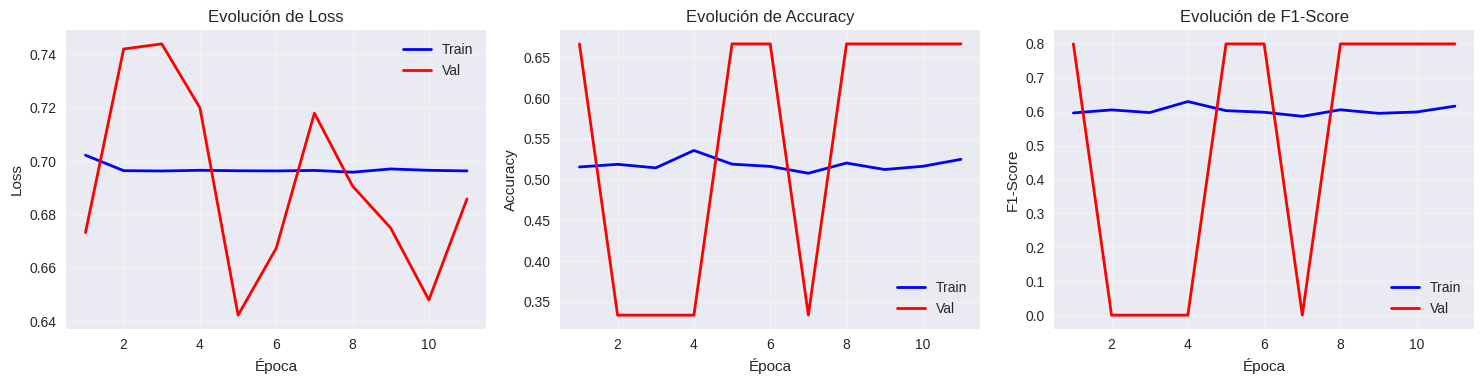

💾 Matriz guardada en: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/confusion_matrix_optuna.png


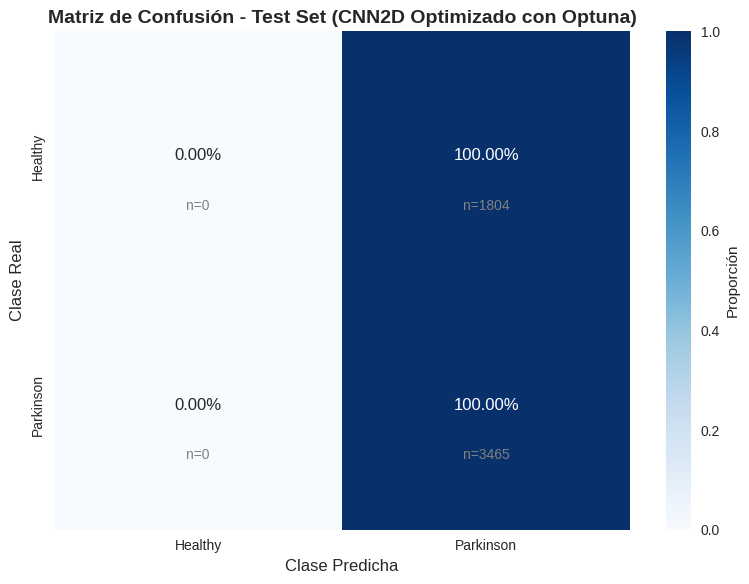

💾 Visualizaciones guardadas:
   - Progreso de entrenamiento: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/training_progress_optuna.png
   - Matriz de confusión: /content/drive/Othercomputers/ZenBook/parkinson-voice-uncertainty/results/cnn_optuna_optimization/confusion_matrix_optuna.png


In [ ]:
# ============================================================
# VISUALIZACIÓN FINAL
# ============================================================

print("="*70)
print("GENERANDO VISUALIZACIONES FINALES")
print("="*70)

# Graficar progreso del entrenamiento final
final_progress_fig = plot_training_history(
    final_history,
    save_path=optuna_results_dir / "training_progress_optuna.png"
)

# Matriz de confusión final
final_cm = final_test_metrics["confusion_matrix"]
final_cm_fig = plot_confusion_matrix(
    final_cm,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Test Set (CNN2D Optimizado con Optuna)",
    save_path=optuna_results_dir / "confusion_matrix_optuna.png",
    show=True
)

print(f"💾 Visualizaciones guardadas:")
print(f"   - Progreso de entrenamiento: {optuna_results_dir / 'training_progress_optuna.png'}")
print(f"   - Matriz de confusión: {optuna_results_dir / 'confusion_matrix_optuna.png'}")

print("="*70)


In [ ]:
# ============================================================
# RESUMEN FINAL DE OPTIMIZACIÓN
# ============================================================

print("="*70)
print("RESUMEN FINAL DE OPTIMIZACIÓN CON OPTUNA")
print("="*70)

print(f"\n🔍 PROCESO DE OPTIMIZACIÓN:")
print(f"   - Configuraciones evaluadas: {len(results_df)}")
print(f"   - Mejor F1-score en validación: {results_df['f1'].max():.4f}")
print(f"   - F1-score promedio: {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

print(f"\n🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS:")
for param, value in best_params.items():
    if param not in ['f1', 'accuracy', 'precision', 'recall', 'val_loss', 'train_loss']:
        print(f"   - {param}: {value}")

print(f"\n📊 RESULTADOS FINALES EN TEST SET:")
final_report = final_test_metrics["classification_report"]
print(f"   - Accuracy:  {final_test_metrics['accuracy']:.4f}")
print(f"   - Precision: {final_report['macro avg']['precision']:.4f}")
print(f"   - Recall:    {final_report['macro avg']['recall']:.4f}")
print(f"   - F1-Score:  {final_test_metrics['f1_macro']:.4f}")

print(f"\n💾 ARCHIVOS GUARDADOS EN {optuna_results_dir}:")
print(f"   - optuna_scan_results.csv          # Todas las configuraciones probadas")
print(f"   - best_params.json                # Mejores hiperparámetros")
print(f"   - optimization_summary.txt        # Resumen de optimización")
print(f"   - best_model_optuna.pth           # Modelo final optimizado")
print(f"   - test_metrics_optuna.json        # Métricas en test set")
print(f"   - training_progress_optuna.png    # Gráfica de entrenamiento")
print(f"   - confusion_matrix_optuna.png   # Matriz de confusión")

print("="*70)
print("OPTIMIZACIÓN CON OPTUNA COMPLETADA EXITOSAMENTE")
print("="*70)
